## 1. 模型架构

### 1.1 编码器

In [1]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers) # LSTM模型
    
    def forward(self, x, hidden):
        x, hidden = self.lstm(x, hidden)
        return hidden  # 只需要输出hidden

### 1.2 解码器

In [2]:
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers)  # LSTM模型
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        x, state = self.lstm(x, hidden)
        x = self.linear(x)
        return x, state

### 1.3. seq2seq模型

In [3]:
class Seq2Seq(nn.Module):
 
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
 
    def forward(self, encoder_inputs, decoder_inputs):
        return self.decoder(decoder_inputs, self.encoder(encoder_inputs))

## 2. 序列到序列模型简单实现

### 2.1 数据集准备

In [4]:
import random

# 数据集生成
soundmark = ['ei',  'bi:',  'si:',  'di:',  'i:',  'ef',  'dʒi:',  'eit∫',  'ai', 'dʒei', 'kei', 'el', 'em', 'en', 'əu', 'pi:', 'kju:',
        'ɑ:', 'es', 'ti:', 'ju:', 'vi:', 'd∧blju:', 'eks', 'wai', 'zi:']

alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q',
         'r','s','t','u','v','w','x','y','z']

t = 10000 #总条数
r = 0.9   #扰动项
seq_len = 6
src_tokens, tgt_tokens = [],[] #原始序列、目标序列列表

for i in range(t):
    src, tgt = [],[]
    for j in range(seq_len):
        ind = random.randint(0,25)
        src.append(soundmark[ind])
        if random.random() < r:
            tgt.append(alphabet[ind])
        else:
            tgt.append(alphabet[random.randint(0,25)])
    src_tokens.append(src)
    tgt_tokens.append(tgt)
src_tokens[:2], tgt_tokens[:2]

([['ei', 'si:', 'wai', 'ei', 'el', 'ef'],
  ['em', 'ti:', 'ai', 'ai', 'ju:', 'ti:']],
 [['a', 'c', 'y', 'a', 'l', 'f'], ['m', 't', 'v', 'i', 'u', 't']])

In [5]:
from collections import Counter                                      #计数类

flatten = lambda l: [item for sublist in l for item in sublist]      #展平数组

# 构建词表
class Vocab:
    def __init__(self, tokens):
        self.tokens = tokens  # 传入的tokens是二维列表
        self.token2index = {'<bos>': 0, '<eos>': 1}  # 先存好特殊词元
        # 将词元按词频排序后生成列表
        self.token2index.update({
            token: index + 2
            for index, (token, freq) in enumerate(
                sorted(Counter(flatten(self.tokens)).items(), key=lambda x: x[1], reverse=True))
        }) 
        #构建id到词元字典
        self.index2token = {index: token for token, index in self.token2index.items()}
 
    def __getitem__(self, query):
        # 单一索引
        if isinstance(query, (str, int)):
            if isinstance(query, str):
                return self.token2index.get(query, 0)
            elif isinstance(query, (int)):
                return self.index2token.get(query, '<unk>')
        # 数组索引
        elif isinstance(query, (list, tuple)):
            return [self.__getitem__(item) for item in query]
 
    def __len__(self):
        return len(self.index2token)

In [6]:
from torch.utils.data import DataLoader, TensorDataset

#实例化source和target词表
src_vocab, tgt_vocab = Vocab(src_tokens), Vocab(tgt_tokens)

#增加结尾标识<eos>
src_data = torch.tensor([src_vocab[line + ['<eos>']] for line in src_tokens])
tgt_data = torch.tensor([tgt_vocab[line + ['<eos>']] for line in tgt_tokens])

# 训练集和测试集比例8比2，batch_size = 16
train_size = int(len(src_data) * 0.8)
test_size = len(src_data) - train_size
batch_size = 16

train_loader = DataLoader(TensorDataset(src_data[:train_size], tgt_data[:train_size]), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(src_data[-test_size:], tgt_data[-test_size:]), batch_size=1)

### 2.2 模型架构

In [7]:
# 定义编码器
class Encoder(nn.Module):
 
    def __init__(self, vocab_size, ebd_size, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, ebd_size)  # 将token表示为embedding
        self.gru = nn.GRU(ebd_size, hidden_size, num_layers=num_layers)
 
    def forward(self, encoder_inputs):
        # encoder_inputs从(batch_size, seq_len)变成(batch_size, seq_len, emb_size)再调整为(seq_len, batch_size, emb_size)
        encoder_inputs = self.embedding(encoder_inputs).permute(1, 0, 2)
        output, hidden = self.gru(encoder_inputs)
        # hidden 的形状为 (num_layers, batch_size, hidden_size)
        # 最后时刻的最后一个隐层的输出的隐状态即为上下文向量
        return hidden

# 定义解码器
class Decoder(nn.Module):
 
    def __init__(self, vocab_size, ebd_size, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, ebd_size)
        # 拼接维度ebd_size + hidden_size
        self.gru = nn.GRU(ebd_size + hidden_size, hidden_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
 
    def forward(self, decoder_inputs, encoder_states):
        '''
            decoder_inputs 为目标序列偏移一位的结果, 由初始形状: (batch_size, seq_len)变为(batch_size, seq_len)
            再调整为(batch_size, seq_len, emb_size) -> (seq_len, batch_size, emb_size)
        '''
        decoder_inputs = self.embedding(decoder_inputs).permute(1, 0, 2)
        context = encoder_states[-1] # 上下文向量取编码器的最后一个隐层的输出
        # context 初始形状为 (batch_size, hidden_size)，为下一步连接，需repeat为(seq_len, batch_size, hidden_size)形式 
        context = context.repeat(decoder_inputs.shape[0], 1, 1)
        output, hidden = self.gru(torch.cat((decoder_inputs, context), -1), encoder_states)
        # logits 的形状为 (seq_len, batch_size, vocab_size)
        logits = self.linear(output)
        return logits, hidden

# seq2seq模型
class Seq2Seq(nn.Module):
 
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
 
    def forward(self, encoder_inputs, decoder_inputs):
        return self.decoder(decoder_inputs, self.encoder(encoder_inputs))

In [8]:
ebd= nn.Embedding(26, 26)
ebd(train_loader.dataset[0][0])

tensor([[ 0.4887, -0.6628, -1.8760, -0.1039, -0.3671, -0.0545,  0.8259,  1.7120,
          1.0536,  0.1105, -2.2157,  0.1826, -0.9814,  0.6896,  1.9313, -0.4203,
          0.4704, -0.3540, -2.5149,  1.6691,  0.7668, -1.2259, -0.0838, -0.8457,
         -0.7388,  0.7919],
        [-0.3271, -0.9200,  1.4683, -1.0719, -0.9968, -0.5890,  0.0442, -0.4679,
         -0.6279, -0.7677, -1.8178,  0.0872,  0.6651, -1.2833, -0.5265, -0.2333,
          0.1615, -0.1019,  0.6508,  0.3404, -1.2946,  0.1573, -0.7420, -2.0256,
          1.6652,  0.7278],
        [-0.3090, -0.6615, -0.2852, -0.4307, -1.7267, -1.2491,  1.1952, -1.7489,
          0.1471,  1.2763, -0.2151, -0.2278,  0.4850,  0.6540,  1.8243,  1.2390,
          0.2089, -1.3072,  0.2947,  0.3472,  1.1848, -1.0279, -0.8024,  0.1165,
         -0.0939,  0.0841],
        [ 0.4887, -0.6628, -1.8760, -0.1039, -0.3671, -0.0545,  0.8259,  1.7120,
          1.0536,  0.1105, -2.2157,  0.1826, -0.9814,  0.6896,  1.9313, -0.4203,
          0.4704, -0.3540

### 2.3 模型训练

In [9]:
from tqdm import *
import matplotlib.pyplot as plt

# 设置超参数
lr = 0.001
num_epochs = 20
hidden_size = 128

# 建立模型
encoder = Encoder(len(src_vocab), len(src_vocab), hidden_size, num_layers=2)
decoder = Decoder(len(tgt_vocab), len(tgt_vocab), hidden_size, num_layers=2)
model = Seq2Seq(encoder, decoder)

# 交叉熵损失及adam优化器
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 记录损失变化
loss_history = []

#开始训练
model.train()
for epoch in tqdm(range(num_epochs)):
    for encoder_inputs, decoder_targets in train_loader:
        encoder_inputs, decoder_targets = encoder_inputs, decoder_targets
        # 偏移一位作为decoder的输入
        # decoder的输入第一位是<bos>
        bos_column = torch.tensor([tgt_vocab['<bos>']] * decoder_targets.shape[0]).reshape(-1, 1)
        decoder_inputs = torch.cat((bos_column, decoder_targets[:, :-1]), dim=1)
        # pred的形状为 (seq_len, batch_size, vocab_size)
        pred, _ = model(encoder_inputs, decoder_inputs)
        # decoder_targets 的形状为 (batch_size, seq_len)，我们需要改变pred的形状以保证它能够正确输入
        # loss 的形状为 (batch_size, seq_len)，其中的每个元素都代表了一个词元的损失
        loss = criterion(pred.permute(1, 2, 0), decoder_targets).mean()

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())



100%|██████████| 20/20 [03:35<00:00, 10.79s/it]


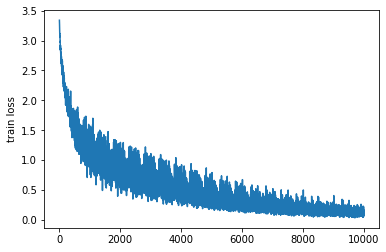

In [10]:
plt.plot(loss_history)
plt.ylabel('train loss')
plt.show()

### 2.4 模型验证

In [11]:
model.eval()
translation_results = []

correct = 0
error = 0
# 因为batch_size是1，所以每次取出来的都是单个句子
for src_seq, tgt_seq in test_loader:
    encoder_inputs = src_seq
    hidden = model.encoder(encoder_inputs)
    pred_seq = [tgt_vocab['<bos>']]
    for _ in range(8):
        # 一步步输出，decoder的输入的形状为(batch_size, seq_len)=(1,1)
        decoder_inputs = torch.tensor(pred_seq[-1]).reshape(1, 1)
        # pred形状为 (seq_len, batch_size, vocab_size) = (1, 1, vocab_size)
        pred, hidden = model.decoder(decoder_inputs, hidden)
        next_token_index = pred.squeeze().argmax().item()
        if next_token_index == tgt_vocab['<eos>']:
            break
        pred_seq.append(next_token_index)
    
    # 去掉开头的<bos>
    pred_seq = tgt_vocab[pred_seq[1:]]
    # 因为tgt_seq的形状为(1, seq_len)，我们需要将其转化成(seq_len, )的形状
    tgt_seq = tgt_seq.squeeze().tolist()
    
    # 需要注意在<eos>之前截断
    if tgt_vocab['<eos>'] in tgt_seq:
        eos_idx = tgt_seq.index(tgt_vocab['<eos>'])
        tgt_seq = tgt_vocab[tgt_seq[:eos_idx]]
    else:
        tgt_seq = tgt_vocab[tgt_seq]
    translation_results.append((' '.join(tgt_seq), ' '.join(pred_seq)))
    
    for i in range(len(tgt_seq)):
        if i >= len(pred_seq) or pred_seq[i] != tgt_seq[i]:
            error += 1
        else:
            correct += 1

print(correct/(correct+error))

0.507


In [12]:
translation_results

[('f d i f h h', 'f d i f r h'),
 ('r g d f x z', 'r m f d s n'),
 ('c v v r l q', 'c v r a l'),
 ('q b f n v x', 'q v f n d e'),
 ('q b x y p y', 'q b x j t b'),
 ('o c c o o t', 'o c o p w'),
 ('n u b r b x', 'n u b r t w'),
 ('b t w z y q', 'b t w s q'),
 ('z c c i s w', 'z c p g w t'),
 ('o t w t c t', 'o v w s c n'),
 ('y o f z y c', 'y o f z o c'),
 ('i e z m d d', 'i e m z d p'),
 ('b n o a l m', 'b n a o l p'),
 ('s y d i u k', 's y u i s c'),
 ('n r w p s e', 'y r p r a p'),
 ('z i l x v i', 'z c l i v'),
 ('n w g h l n', 'w n g h r c'),
 ('b b o o b s', 'b b o r a b'),
 ('x b t y h n', 'x b y h n c'),
 ('z f l r d w', 'z f l r o w'),
 ('e m q d m i', 'e q g d m h'),
 ('v f s t v y', 'v f s t v b'),
 ('u x k e a s', 'u x k a e p'),
 ('a o u i i y', 'a o i x v q'),
 ('o d c i h p', 'o d q i c h'),
 ('f o a z v t', 'f o a t d x'),
 ('i b i s a t', 'i b o j t b'),
 ('g e s t f s', 'g s e o r x'),
 ('g g t u h q', 'g h u u h g'),
 ('p v t b j p', 'p v t b j p'),
 ('e o n t h s', '